# Overview

- EDA
- sample/feature selection
- baseline model
- validation
- submit

【基本の考え方】
- Private LB がテストデータで評価されるため、テストデータに基づいてクリーニング、特徴量選択、訓練データの選択、を行う。
- nb06 のデータセットを変えて公開されたデータセット all-in-one-dataset 版をつくる。

In [1]:
# Directories
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv
/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv
/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv
/kaggle/input/all-in-one-dataset/__results__.html
/kaggle/input/all-in-one-dataset/__resultx__.html
/kaggle/input/all-in-one-dataset/__notebook__.ipynb
/kaggle/input/all-in-one-dataset/all_in_one_jigsaw.csv
/kaggle/input/all-in-one-dataset/__output__.json
/kaggle/input/all-in-one-dataset/custom.css
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/sample_submission.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/all_data.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_public_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/test_private_expanded.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/toxicity_individual_annotations.csv
/kaggle/input/jigsaw-unintended-bias-in-toxicity-classification/t

In [2]:
# Parameters
DEBUG_FLAG = False
VERSION = 'nb06'

SUBMISSION_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv'
VALIDATION_DATA_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv'
COMMENTS_SCORE_PATH = '/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv'
ALLINONE_TRAIN_PATH = '/kaggle/input/all-in-one-dataset/all_in_one_jigsaw.csv'

N_SPLITS = 5 if not DEBUG_FLAG else 2

In [3]:
# Modules
import re
import sys
import time

import datatable as dt
import nltk
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn3
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, SGDClassifier, SGDRegressor
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold

sys.setrecursionlimit(5000)

In [4]:
# My functions
def read_df():
    valid = dt.fread(VALIDATION_DATA_PATH).to_pandas()
    test = dt.fread(COMMENTS_SCORE_PATH).to_pandas()
    submission = dt.fread(SUBMISSION_PATH).to_pandas()
    allinone = dt.fread(ALLINONE_TRAIN_PATH).to_pandas()
    
    if DEBUG_FLAG:
        valid = valid.sample(n=1000).reset_index(drop=True)
        test = test.sample(n=1000).reset_index(drop=True)
        allinone = allinone.sample(n=1000).reset_index(drop=True)
    
    return valid, test, submission, allinone

In [5]:
valid, test, submission, allinone = read_df()

print(f'valid shape: {valid.shape}')
print(f'test shape: {test.shape}')
print(f'submission shape: {submission.shape}')
print(f'allinone shape: {allinone.shape}')

valid shape: (30108, 3)
test shape: (7537, 2)
submission shape: (7537, 2)
allinone shape: (2223065, 11)


In [6]:
display(valid.head())
display(test.head())
display(submission.head())
display(allinone.head())

,worker,less_toxic,more_toxic
0,313,This article sucks \n\nwoo woo wooooooo,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...
1,188,"""And yes, people should recognize that but the...",Daphne Guinness \n\nTop of the mornin' my fav...
2,82,"Western Media?\n\nYup, because every crime in...","""Atom you don't believe actual photos of mastu..."
3,347,And you removed it! You numbskull! I don't car...,You seem to have sand in your vagina.\n\nMight...
4,539,smelly vagina \n\nBluerasberry why don't you ...,"hey \n\nway to support nazis, you racist"


,comment_id,text
0,114890,"""\n \n\nGjalexei, you asked about whether ther..."
1,732895,"Looks like be have an abuser , can you please ..."
2,1139051,I confess to having complete (and apparently b...
3,1434512,"""\n\nFreud's ideas are certainly much discusse..."
4,2084821,It is not just you. This is a laundry list of ...


,comment_id,score
0,114890,0.5
1,732895,0.5
2,1139051,0.5
3,1434512,0.5
4,2084821,0.5


,C0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,dataset,comment_text_processed
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,explanation why the edits made under my userna...
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,d'aww he matches this background colour i'm se...
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,hey man i'm really not trying to edit war it's...
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,more i can't make any real suggestions on impr...
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0.0,0.0,0.0,0.0,0.0,0.0,toxic_comment,you sir are my hero any chance you remember wh...


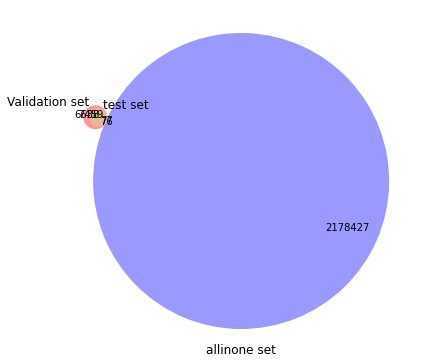

In [7]:
valid_unique_text = set(pd.concat([valid['less_toxic'], valid['more_toxic']]).unique())
test_unique_text = set(test['text'].unique())
allinone_unique_text = set(allinone['comment_text_processed'].unique())

plt.figure(figsize=(6,6))
venn3(subsets=(valid_unique_text, test_unique_text, allinone_unique_text),
      set_labels=('Validation set', 'test set', 'allinone set'))
plt.tight_layout()
plt.show()

test は validation に含まれている。一方で test は allinone に完全に含まれているわけではない。これにより、allinone を訓練データとして使う場合、同じテキストのサンプルを選択するよりも、予め特徴抽出した上で、似ているサンプルを選択するのがよいのかもしれない。

方針としては、特徴抽出して、adversarial validation により似ているサンプルセットを使って学習、予測という流れ。

In [8]:
# クリーニング関数
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None, whitelist=None):
    # clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    
    # remove numbers
    text = re.sub(r'[\d]', '', text)
            
    # Tokenize (convert from string to list)
    lst_text = text.split()
    
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
                
    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    
    # white words list
    if whitelist is not None:
        lst_text = [word for word in lst_text if word in whitelist]
        
    # back to string from list
    text = ' '.join(lst_text)
    
    return text

In [9]:
%%time
stop_words = list(text.ENGLISH_STOP_WORDS)

# test のクリーニング
test['text_clean'] = test['text'].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=None)
)

test_words = set(' '.join(test['text_clean']).split())
print(f'test_words size: {len(test_words)}')

test_words size: 23636
CPU times: user 13.7 s, sys: 127 ms, total: 13.8 s
Wall time: 13.8 s


In [10]:
%%time

# valid のクリーニング
valid_unique_text = pd.Series(pd.concat([valid['less_toxic'], valid['more_toxic']]).unique())
valid_unique_text_cleaned = valid_unique_text.apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
)
valid_unique_text_dic = {text: cleaned_text for text, cleaned_text in zip(valid_unique_text, valid_unique_text_cleaned)}
valid['less_toxic_clean'] = valid['less_toxic'].map(valid_unique_text_dic)
valid['more_toxic_clean'] = valid['more_toxic'].map(valid_unique_text_dic)

# allinone のクリーニング
allinone = allinone.rename(columns={'comment_text_processed': 'text'})
allinone['text_clean'] = allinone['text'].apply(lambda x: 
    utils_preprocess_text(x, flg_stemm=True, flg_lemm=True, lst_stopwords=stop_words, whitelist=test_words)
)

CPU times: user 41min 57s, sys: 4.92 s, total: 42min 2s
Wall time: 42min 3s


In [11]:
display(valid[['less_toxic', 'less_toxic_clean']])
display(valid[['more_toxic', 'more_toxic_clean']])
display(test[['text', 'text_clean']])
display(allinone[['text', 'text_clean']])

,less_toxic,less_toxic_clean
0,This article sucks \n\nwoo woo wooooooo,articl suck woo woo wooooooo
1,"""And yes, people should recognize that but the...",ye peopl recogn usual dont object hear direct ...
2,"Western Media?\n\nYup, because every crime in...",western medium yup crime entir world caus west...
3,And you removed it! You numbskull! I don't car...,remov numbskul dont care say anymor life ahead...
4,smelly vagina \n\nBluerasberry why don't you ...,smelli vagina bluerasberri dont model cheesi b...
...,...,...
30103,I'm sorry. I'm not an admin. I will give you t...,im sorri im admin piec advic edit page away gu...
30104,I'm sorry. I'm not an admin. I will give you t...,im sorri im admin piec advic edit page away gu...
30105,"wow...\nare you out of your mind, how was my e...",wow mind edit talk page vandal simpli explain ...
30106,"wow...\nare you out of your mind, how was my e...",wow mind edit talk page vandal simpli explain ...


,more_toxic,more_toxic_clean
0,WHAT!!!!!!!!?!?!!?!?!!?!?!?!?!!!!!!!!!!!!!!!!!...,wher sexi pic gone main page
1,Daphne Guinness \n\nTop of the mornin' my fav...,daphn guin mornin favourit alien life form im ...
2,"""Atom you don't believe actual photos of mastu...",atom dont believ actual photo masturb sexual e...
3,You seem to have sand in your vagina.\n\nMight...,sand vagina want wash stink hole bitch
4,"hey \n\nway to support nazis, you racist",hey way support nazi racist
...,...,...
30103,get out my large penis,larg peni
30104,get out my large penis,larg peni
30105,Piss off you slant eyed-gook,piss slant eyedgook
30106,Piss off you slant eyed-gook,piss slant eyedgook


,text,text_clean
0,"""\n \n\nGjalexei, you asked about whether ther...",gjalexei ask antieditori polici call wikipedia...
1,"Looks like be have an abuser , can you please ...",look like abus look thank
2,I confess to having complete (and apparently b...,confess have complet appar bliss ignor jordan ...
3,"""\n\nFreud's ideas are certainly much discusse...",freud idea certainli discus today agre grappl ...
4,It is not just you. This is a laundry list of ...,just laundri list stupid alleg scoop godknowsw...
...,...,...
7532,"Go away, you annoying vandal.",away annoy vandal
7533,This user is a vandal.,user vandal
7534,""" \n\nSorry to sound like a pain, but one by f...",sorri sound like pain follow tad stalk honesti...
7535,Well it's pretty fucking irrelevant now I'm un...,pretti fuck irrelev im unblock aint


,text,text_clean
0,explanation why the edits made under my userna...,explan edit usernam hardcor fan revert werent ...
1,d'aww he matches this background colour i'm se...,match background colour im seemingli stuck tha...
2,hey man i'm really not trying to edit war it's...,hey man im realli tri edit war just guy consta...
3,more i can't make any real suggestions on impr...,make real suggest improv wonder section statis...
4,you sir are my hero any chance you remember wh...,sir hero chanc rememb page that
...,...,...
2223060,another man shamming article if white men did ...,man sham articl white men did work canada toda...
2223061,no matter what is put in front of you regardin...,matter regard crime commit tran peopl attempt ...
2223062,the democrat party aided and abetted by it's m...,democrat parti aid abet msm flunki perpetr act...
2223063,i just don't find her a very good representati...,just dont good represent transexu commun just ...


In [12]:
# クリーニングにより空文字列になった文字列を抽出
print(sum(test['text_clean'].apply(lambda x: len(x)) == 0), '/', len(test))
print(sum(valid['less_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
print(sum(valid['more_toxic_clean'].apply(lambda x: len(x)) == 0), '/', len(valid))
print(sum(allinone['text_clean'].apply(lambda x: len(x)) == 0), '/', len(allinone))

1 / 7537
21 / 30108
21 / 30108
10358 / 2223065


In [13]:
# 空文字列の行を除く
allinone['word_size'] = allinone['text_clean'].apply(lambda x: len(x))
valid['less_toxic_size'] = valid['less_toxic_clean'].apply(lambda x: len(x))
valid['more_toxic_size'] = valid['more_toxic_clean'].apply(lambda x: len(x))

allinone = allinone.query('word_size != 0')
valid = valid.query('less_toxic_size != 0 | more_toxic_size != 0')

In [14]:
# preparing adversarial validation
advval_train_X = pd.concat([allinone['text_clean'], test['text_clean']])
advval_train_y = pd.concat([pd.Series(np.ones(allinone.shape[0])), pd.Series(np.zeros(test.shape[0]))])
advval_valid_less_X = valid['less_toxic_clean']
advval_valid_more_X = valid['more_toxic_clean']

print(f'advval_train_X shape: {advval_train_X.shape}')
print(f'advval_train_y shape: {advval_train_y.shape}')

advval_train_X shape: (2220244,)
advval_train_y shape: (2220244,)


In [15]:
%%time

# 特徴抽出
print(f'feature extracting ...')
advval_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    min_df=3,
    max_df=0.5, 
    max_features=100_000,
    analyzer='word',
    ngram_range=(1, 1)
)
advval_train_X_tfidf = advval_tfidf.fit_transform(advval_train_X)
advval_train_X_tfidf_feature_names = advval_tfidf.get_feature_names()
advval_train_X_tfidf_vocab = advval_tfidf.vocabulary_
advval_valid_less_X_tfidf = advval_tfidf.transform(advval_valid_less_X)
advval_valid_more_X_tfidf = advval_tfidf.transform(advval_valid_more_X)

print('Total number of features:', advval_train_X_tfidf.shape[1])

feature extracting ...
Total number of features: 17840
CPU times: user 1min 20s, sys: 1.92 s, total: 1min 22s
Wall time: 1min 22s


In [16]:
# idf ranking
idf = {'word': advval_tfidf.get_feature_names(), 'weight': advval_tfidf.idf_}
pd.DataFrame(idf).sort_values('weight', ascending=False)

,word,weight
2679,chlorpromazin,14.226834
1817,bola,14.226834
13721,scholer,14.226834
1814,boiz,14.226834
13725,schooli,14.226834
...,...,...
9414,make,3.361590
4506,dont,3.271537
11601,peopl,3.066026
8420,just,3.051839


In [17]:
# adversarial validation
def adversarial_validation(train_X, train_y, tfidf):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    stkf = StratifiedKFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(stkf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        clf = SGDClassifier(
            loss='log', 
            class_weight='balanced',
            max_iter=10000, 
            tol=1e-3, 
            n_jobs=-1
        )

        clf.fit(X_trn_tfidf, y_trn)

        # 推論
        print(f'predicting ...')
        val_pred = clf.predict_proba(X_val_tfidf)[:, 1]
        oof_train[valid_idx] = val_pred
        models.append(clf)

        # 評価
        print(f'validation ...')
        score_auc = roc_auc_score(y_val, val_pred)
        scores.append(score_auc)
        elapsed = time.time() - start
        print(f'fold {fold_id} - score: {score_auc:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    print(f'Average AUC: {sum(scores)/N_SPLITS:.6f}')
    
    return oof_train, models

In [18]:
%%time
advval_oof_train, advval_models = adversarial_validation(advval_train_X, advval_train_y, advval_tfidf)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 1776195
Total number of valid samples: 444049
training ...
predicting ...
validation ...
fold 0 - score: 0.937122, elapsed time: 95.71 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 1776195
Total number of valid samples: 444049
training ...
predicting ...
validation ...
fold 1 - score: 0.937268, elapsed time: 99.56 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 1776195
Total number of valid samples: 444049
training ...
predicting ...
validation ...
fold 2 - score: 0.938635, elapsed time: 97.53 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 3
preprocessing ...
Total number of train samples: 1776195
Total

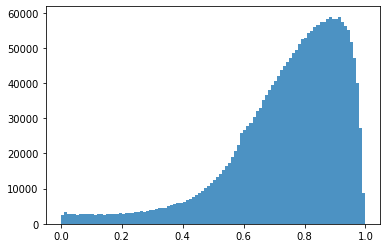

In [19]:
# スコア分布
plt.figure()
plt.hist(advval_oof_train, alpha=.8, bins=100)
plt.show()

In [20]:
advval_oof_train = pd.DataFrame({'oof_train': advval_oof_train, 'y': advval_train_y})
advval_oof_train

,oof_train,y
0,0.109209,1.0
1,0.432484,1.0
2,0.034368,1.0
3,0.477426,1.0
4,0.355134,1.0
...,...,...
7532,0.097160,0.0
7533,0.024058,0.0
7534,0.118862,0.0
7535,0.061821,0.0


In [21]:
# 訓練データのうちテストデータに近いサンプルを抽出
advval_oof_train.query('oof_train < 0.5 & y == 1')

,oof_train,y
0,0.109209,1.0
1,0.432484,1.0
2,0.034368,1.0
3,0.477426,1.0
4,0.355134,1.0
...,...,...
2212670,0.375019,1.0
2212682,0.480868,1.0
2212686,0.421688,1.0
2212693,0.416846,1.0


In [22]:
advval_train_idx = advval_oof_train.query('oof_train < 0.5 & y == 1').index
print(len(advval_train_idx))

218796


In [23]:
# preparing main training data
main_train_X = allinone.iloc[advval_train_idx]['text_clean']
main_train_y = allinone.iloc[advval_train_idx][['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
main_train_y += allinone.iloc[advval_train_idx]['severe_toxic']
main_train_y /= main_train_y.max()
main_valid_less_X = valid['less_toxic_clean']
main_valid_more_X = valid['more_toxic_clean']

print(f'main_train_X shape: {advval_train_X.shape}')
print(f'main_train_y shape: {advval_train_y.shape}')
print(f'main_valid_less_X shape: {main_valid_less_X.shape}')
print(f'main_valid_more_X shape: {main_valid_more_X.shape}')

main_train_X shape: (2220244,)
main_train_y shape: (2220244,)
main_valid_less_X shape: (30108,)
main_valid_more_X shape: (30108,)


In [24]:
# 特徴抽出
print(f'feature extracting ...')
main_tfidf = TfidfVectorizer(
    stop_words=stop_words,
    min_df=3,
    max_df=0.5, 
    max_features=100_000,
    analyzer='word',
    ngram_range=(1, 1)
)

main_train_X_tfidf = main_tfidf.fit_transform(main_train_X)
main_train_X_tfidf_feature_names = main_tfidf.get_feature_names()
main_train_X_tfidf_vocab = main_tfidf.vocabulary_
main_valid_less_X_tfidf = main_tfidf.transform(main_valid_less_X)
main_valid_more_X_tfidf = main_tfidf.transform(main_valid_more_X)

print('Total number of features:', main_train_X_tfidf.shape[1])

feature extracting ...
Total number of features: 14620


In [25]:
# idf ranking
idf = {'word': main_tfidf.get_feature_names(), 'weight': main_tfidf.idf_}
pd.DataFrame(idf).sort_values('weight', ascending=False)

,word,weight
5891,hiram,11.909605
8909,nussl,11.909605
12180,stacker,11.909605
12185,staid,11.909605
8898,numba,11.909605
...,...,...
3946,edit,3.001316
7439,like,2.986480
14256,wikipedia,2.884812
9298,page,2.744838


In [26]:
# main
def main_training(train_X, train_y, tfidf):

    models = []
    oof_train = np.zeros((train_X.shape[0],))
    scores = []

    kf = KFold(
        n_splits=N_SPLITS, 
        shuffle=True,
        random_state=None
    )

    # 交差検証
    for fold_id, (train_idx, valid_idx) in enumerate(kf.split(train_X, train_y)):
        start = time.time()
        print(f'* ' * 40)
        print(f'fold_id: {fold_id}')

        # 訓練データ、評価データ、テストデータを整形
        print(f'preprocessing ...')
        X_trn = train_X.iloc[train_idx].reset_index(drop=True)
        X_val = train_X.iloc[valid_idx].reset_index(drop=True)
        y_trn = train_y.iloc[train_idx].reset_index(drop=True)
        y_val = train_y.iloc[valid_idx].reset_index(drop=True)

        X_trn_tfidf = tfidf.transform(X_trn)
        X_val_tfidf = tfidf.transform(X_val)

        print('Total number of train samples:', X_trn_tfidf.shape[0])
        print('Total number of valid samples:', X_val_tfidf.shape[0])

        # 訓練
        print(f'training ...')
        reg = Ridge(
            max_iter=10000, 
            tol=1e-3
        )

        reg.fit(X_trn_tfidf, y_trn)

        # 推論
        print(f'predicting ...')
        val_pred = reg.predict(X_val_tfidf)
        oof_train[valid_idx] = val_pred
        models.append(reg)

        # 評価
        print(f'validation ...')
        score_mse = mean_squared_error(y_val, val_pred)
        scores.append(score_mse)
        elapsed = time.time() - start
        print(f'fold {fold_id} - score: {score_mse:.6f}, elapsed time: {elapsed:.2f} [sec]')

    print(f'* ' * 40)
    print(f'Average MSE: {sum(scores)/N_SPLITS:.6f} Average RMSE: {np.sqrt(sum(scores)/N_SPLITS):.6f}')
    
    return oof_train, models

In [27]:
%%time
main_oof_train, main_models = main_training(main_train_X, main_train_y, main_tfidf)

* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 0
preprocessing ...
Total number of train samples: 175036
Total number of valid samples: 43760
training ...
predicting ...
validation ...
fold 0 - score: 0.006394, elapsed time: 9.37 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 1
preprocessing ...
Total number of train samples: 175037
Total number of valid samples: 43759
training ...
predicting ...
validation ...
fold 1 - score: 0.006648, elapsed time: 9.34 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 2
preprocessing ...
Total number of train samples: 175037
Total number of valid samples: 43759
training ...
predicting ...
validation ...
fold 2 - score: 0.006576, elapsed time: 9.36 [sec]
* * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * 
fold_id: 3
preprocessing ...
Total number of train samples: 175037
Total number of

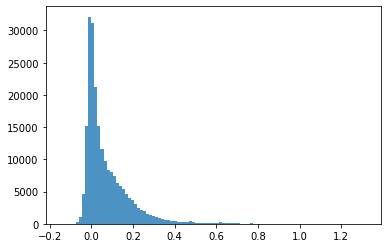

In [28]:
# スコア分布
plt.figure()
plt.hist(main_oof_train, alpha=.8, bins=100)
plt.show()

In [29]:
# adversarial validation によりテストデータに近い評価データを作成
advval_score_valid_less_toxic = np.array([clf.predict_proba(advval_valid_less_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / len(advval_models)
advval_score_valid_more_toxic = np.array([clf.predict_proba(advval_valid_more_X_tfidf)[:, 1] for clf in advval_models]).sum(axis=0) / len(advval_models)

test_like_valid_idx = (advval_score_valid_less_toxic < 0.5) & (advval_score_valid_more_toxic < 0.5)
print(sum(test_like_valid_idx), '/', len(test_like_valid_idx))

21908 / 30108


In [30]:
# validation score
preds_less_toxic = np.array([reg.predict(main_valid_less_X_tfidf[test_like_valid_idx]) for reg in main_models]).sum(axis=0)
preds_more_toxic = np.array([reg.predict(main_valid_more_X_tfidf[test_like_valid_idx]) for reg in main_models]).sum(axis=0)

print((preds_less_toxic < preds_more_toxic).mean())

0.6924411174000366


In [31]:
test_X_tfidf = main_tfidf.transform(test['text_clean'])
preds_test = np.array([reg.predict(test_X_tfidf) for reg in main_models]).sum(axis=0) / N_SPLITS
if not DEBUG_FLAG:
    submission['score'] = preds_test
    display(pd.DataFrame(pd.Series(submission['score'].ravel()).describe()).transpose())

,count,mean,std,min,25%,50%,75%,max
0,7537.0,0.12785,0.145304,-0.059768,0.032167,0.078396,0.170854,0.934178


In [32]:
submission.to_csv('submission.csv', index=False)
submission

,comment_id,score
0,114890,0.055964
1,732895,0.028097
2,1139051,0.041139
3,1434512,0.026192
4,2084821,0.078077
...,...,...
7532,504235362,0.034387
7533,504235566,0.004865
7534,504308177,0.011687
7535,504570375,0.199273
